<a href="https://colab.research.google.com/github/aiqohaki10/Cursor/blob/master/Hierarchical%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Langkah-Langkah Analisis Data dan Clustering
Berikut adalah kerangka untuk menyelesaikan tugas clustering dengan data ini:**
1. Muat dan Tinjau Dataset
Membaca dataset menggunakan pandas.
Melihat jumlah baris dan kolom, sampel data, serta tipe datanya:

In [21]:
import pandas as pd

# Baca dataset
df = pd.read_csv('/content/drive/MyDrive/SainsData/data.csv', encoding='latin-1')

# Tinjau dataset
print(df.shape)
print(df.info())
print(df.head())


(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029

2. Pembersihan Data (Data Cleaning)

- Menghapus nilai yang hilang:

In [22]:
df.dropna(subset=['CustomerID'], inplace=True)


- Menghapus transaksi yang tidak valid (misalnya, jumlah atau harga negatif):

In [23]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


3. Fitur Baru untuk Analisis

- Total Pendapatan: Buat kolom baru untuk menghitung total pendapatan per transaksi:


In [24]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


<ipython-input-24-18878337d6d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


- Ekstraksi waktu : Buat kolom tambahan seperti hari, bulan, atau jam transaksi:


In [25]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.month


4. Persiapan untuk Clustering
- Gunakan data seperti:
 - Jumlah transaksi (InvoiceNo).
 - Total spending per customer.
 - Jumlah produk yang dibeli.
 - Negara (jika diperlukan untuk segmentasi berdasarkan lokasi).

Contoh agregasi data:

In [26]:
customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',   # Total pengeluaran
    'InvoiceNo': 'nunique',  # Jumlah transaksi
    'Quantity': 'sum'        # Total barang dibeli
}).reset_index()

print(customer_data.head())


   CustomerID  TotalPrice  InvoiceNo  Quantity
0     12346.0    77183.60          1     74215
1     12347.0     4310.00          7      2458
2     12348.0     1797.24          4      2341
3     12349.0     1757.55          1       631
4     12350.0      334.40          1       197


5. Normalisasi Data
- Sebelum clustering, normalisasi data menggunakan MinMaxScaler:

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['TotalPrice', 'InvoiceNo', 'Quantity']])


6. Clustering Hierarkis

- Dendrogram: Visualisasi untuk menentukan jumlah cluster.



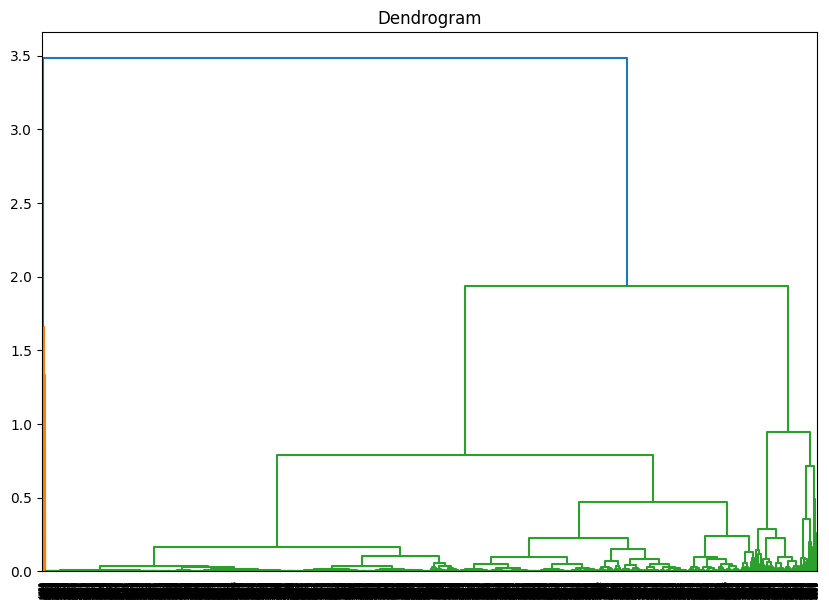

In [28]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(customer_data_scaled, method='ward'))
plt.title('Dendrogram')
plt.show()


**Agglomerative Clustering:**

In [29]:
from sklearn.cluster import AgglomerativeClustering

# Perbaikan: ganti affinity menjadi metric
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
clusters = hc.fit_predict(customer_data_scaled)
customer_data['Cluster'] = clusters


- Menghitung rata-rata Quantity dan UnitPrice per cluster dan menilai cluster berdasarkan kategori rendah, sedang, atau tinggi.

In [30]:
# Merge 'Cluster' column from customer_data to df based on 'CustomerID'
df = pd.merge(df, customer_data[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# Now you can group by 'Cluster' in df:
cluster_summary = df.groupby('Cluster')[['Quantity', 'UnitPrice']].mean()
print(cluster_summary)

           Quantity  UnitPrice
Cluster                       
0        105.688803   3.525898
1          8.446621   3.060130
2          9.716426   3.025376
3         14.043935   3.298178


**Interpretasi dan Penentuan Cluster**

- Setelah menghitung rata-rata, kita menganalisis output dan memberikan label seperti berikut:


In [31]:
# Menampilkan rata-rata dan interpretasi
print("\nInterpretasi Cluster:")
for i, row in cluster_summary.iterrows():
    quantity_avg = row['Quantity']
    price_avg = row['UnitPrice']
    if quantity_avg < 30 and price_avg < 10:
        print(f"Cluster {i} - Kuantitas: Rendah, Harga: Rendah")
    elif quantity_avg >= 30 and price_avg >= 10:
        print(f"Cluster {i} - Kuantitas: Tinggi, Harga: Tinggi")
    else:
        print(f"Cluster {i} - Kuantitas: Sedang, Harga: Sedang")



Interpretasi Cluster:
Cluster 0 - Kuantitas: Sedang, Harga: Sedang
Cluster 1 - Kuantitas: Rendah, Harga: Rendah
Cluster 2 - Kuantitas: Rendah, Harga: Rendah
Cluster 3 - Kuantitas: Rendah, Harga: Rendah


7. Visualisasi Hasil

- Gunakan seaborn atau plotly untuk visualisasi hasil clustering:

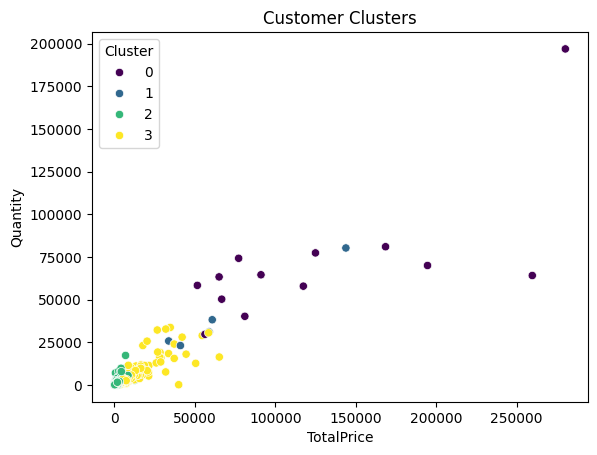

In [32]:
import seaborn as sns

sns.scatterplot(
    x=customer_data['TotalPrice'],
    y=customer_data['Quantity'],
    hue=customer_data['Cluster'],
    palette='viridis'
)
plt.title('Customer Clusters')
plt.show()


In [33]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Terapkan Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
clusters = hc.fit_predict(customer_data_scaled)

# Perbaikan: Ganti unique_invoices dengan customer_data
customer_data['Cluster'] = clusters

# Hitung Silhouette Score
score = silhouette_score(customer_data_scaled, clusters, metric='euclidean')

print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.777


Setelah proses clustering dan visualisasi, dataset akhir yang dihasilkan perlu menyertakan semua kolom asli dan kolom tambahan hasil analisis, seperti TotalPrice, dan Cluster. Berikut adalah kode untuk menyimpan dataset hasil ke file CSV:

In [34]:
# Tambahkan cluster ke dataset asli
# Gabungan customer_data dengan data awal berdasarkan CustomerID
df_final = df.merge(customer_data[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# Simpan dataset hasil ke dalam file CSV
df_final.to_csv('ecommerce_clustered_data.csv', index=False)

print("Dataset akhir telah disimpan sebagai 'ecommerce_clustered_data.csv'.")


Dataset akhir telah disimpan sebagai 'ecommerce_clustered_data.csv'.
